# <center> Tweet Sentiment Analysis  </center> <br> 

### Estimation of the emotion of a tweet based on words of the tweet text and using an LSTM

### The dataset consists of 40,000 tweets with sentiments. 
### The sentiment is one of five (5) classes. The dataset features are:
- Tweet ID (ignore)
- Sentiment (categorical): tweet sentiment (target)
- Author (ignore)
- Content (string): text content of the tweet

License: Public domain (CC0)

Data: https://data.world/crowdflower/sentiment-analysis-in-text

In [18]:
import numpy as np
import pandas as pd
import nltk
import seaborn as sns

from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation, Dropout, BatchNormalization
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords 
from string import punctuation
from sklearn.model_selection import train_test_split
from livelossplot import PlotLossesKeras
from matplotlib import pyplot as plt

In [19]:
df = pd.read_csv("text_emotion.csv")
df.head(5)

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   author     40000 non-null  object
 3   content    40000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


# Get max tweet length

In [21]:
max_tweet_length= df["content"].str.len().max()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, 'empty'),
  Text(1, 0, 'sadness'),
  Text(2, 0, 'enthusiasm'),
  Text(3, 0, 'neutral'),
  Text(4, 0, 'worry'),
  Text(5, 0, 'surprise'),
  Text(6, 0, 'love'),
  Text(7, 0, 'fun'),
  Text(8, 0, 'hate'),
  Text(9, 0, 'happiness'),
  Text(10, 0, 'boredom'),
  Text(11, 0, 'relief'),
  Text(12, 0, 'anger')])

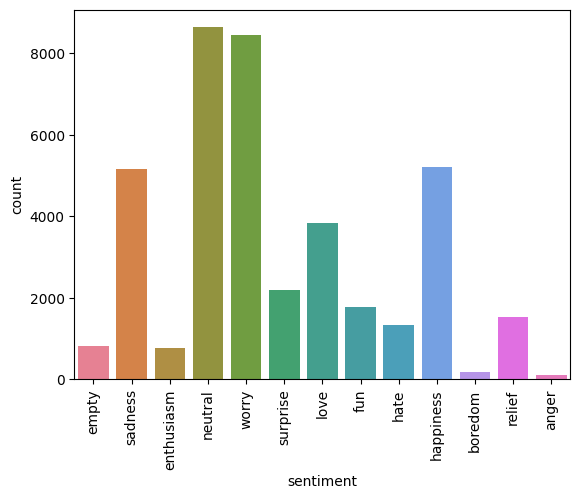

In [22]:
sns.countplot(x ='sentiment', data = df, hue='sentiment')
plt.xticks(rotation = 90)